<a href="https://colab.research.google.com/github/ZhanbolEP/TrafficVolume/blob/main/Traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Traffic Volume Predictor using PyTorch**


Traffic data fluctuates constantly or is affected by time. Predicting it can be challenging, but this task will help sharpen your time-series skills. With deep learning, you can use abstract patterns in data that can help boost predictability.

Your task is to build a system that can be applied to help you predict traffic volume or the number of vehicles passing at a specific point and time. Determining this can help reduce road congestion, support new designs for roads or intersections, improve safety, and more! Or, you can use to help plan your commute to avoid traffic!

The dataset provided contains the hourly traffic volume on an interstate highway in Minnesota, USA. It also includes weather features and holidays, which often impact traffic volume.

Time to predict some traffic!

### The data:

The dataset is collected and maintained by UCI Machine Learning Repository. The target variable is `traffic_volume`. The dataset contains the following and has already been normalized and saved into training and test sets:

```
# This is formatted as code
`train_scaled.csv`, `test_scaled.csv`
| Column     |      Type       | Description              |
|------------|------------|--------------------------|
|`temp`                   |Numeric            |Average temp in kelvin|
|`rain_1h`                |Numeric            |Amount in mm of rain that occurred in the hour|
|`snow_1h`                |Numeric            |Amount in mm of snow that occurred in the hour|
|`clouds_all`             |Numeric            |Percentage of cloud cover|
|`date_time`              |DateTime           |Hour of the data collected in local CST time|
|`holiday_` (11 columns)            |Categorical        |US National holidays plus regional holiday, Minnesota State Fair|
|`weather_main_` (11 columns)       |Categorical     |Short textual description of the current weather|
|`weather_description_` (35 columns)|Categorical|Longer textual description of the current weather|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|
|`hour_of_day`|Numeric|The hour of the day|
|`day_of_week`|Numeric|The day of the week (0=Monday, Sunday=6)|
|`day_of_month`|Numeric|The day of the month|
|`month`|Numeric|The number of the month|
|`traffic_volume`         |Numeric            |Hourly I-94 ATR 301 reported westbound traffic volume|
```



In [ ]:
# Import the relevant libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Read the traffic data from the CSV training and test files
train_scaled_df = pd.read_csv('train_scaled.csv')
test_scaled_df = pd.read_csv('test_scaled.csv')

# Convert the DataFrame to NumPy arrays
train_scaled = train_scaled_df.to_numpy()
test_scaled = test_scaled_df.to_numpy()



---



In this cell, we define a function to split the traffic data into sequences of 12 hours each, along with their corresponding traffic volume target. These sequences will be used to train the model to predict traffic volume based on past data.

In [ ]:
def create_sequences(data, seq_length, y_col_idx):
    """
    Generates input sequences and corresponding target values for time-series data.
    Parameters: input data, number of time steps in each sequence, target column name.
    Returns: NumPy arrays for input sequences an target values.
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, y_col_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences for the training and test data
X_train, y_train = create_sequences(train_scaled, 12, -1)
X_test, y_test = create_sequences(test_scaled, 12, -1)



---


This cell converts the sequences into PyTorch `TensorDataset` objects and loads them into `DataLoader` batches. This setup allows the model to efficiently process the data during training and testing.

In [ ]:
# Create a TensorDataset for the training and test data for PyTorch modeling compatibility
dataset_train = TensorDataset(
    torch.tensor(X_train.astype(np.float32)).float(), torch.tensor(y_train.astype(np.float32)).float(),
)
dataset_test = TensorDataset(
    torch.tensor(X_test.astype(np.float32)).float(), torch.tensor(y_test.astype(np.float32)).float(),
)

# Create a DataLoader for the training and test data, loading the data in batches and shuffling the data
# Batch size 64 is a common choice to balance training speed and memory usage
# Shuffle is True to reduce the risk of overfitting
# Shuffle is False for test data following best practices
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)



---

This cell defines the **TrafficVolume** LSTM model. It processes time-series traffic data using an LSTM layer followed by a fully connected layer with activation, allowing it to learn patterns and predict traffic volume.

In [ ]:
# Define an LSTM network
class TrafficVolume(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the LSTM layer
        # 66 for the input_size is the number of features
        # 64 is a common choice for hidden size
        # 2 layers are selected to help learn more complex time-series patterns
        self.lstm = nn.LSTM(
            input_size=66,
            hidden_size=64,
            num_layers=2,
            batch_first=True
        )
        # Define the activation function
        self.relu = nn.LeakyReLU()

        # Define the fully connected layer
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        # Capture the final hidden state
        _, (h_0, _) = self.lstm(x)
        # Take the hidden state from the last layer
        out = h_0[-1]
        # Apply ReLU
        return self.relu(self.fc1(out))

# Set-up for training
n_features = 66
hidden_size = 64
num_layers = 2

# Initialize the model, saving it to traffic_model
traffic_model = TrafficVolume()



---

This cell trains the LSTM model using the training data for **2 epoch**s. It uses **Mean Squared Error** (MSE) as the loss function and the **Adam optimizer** to update model weights for better traffic volume predictions.

In [6]:
# Define the loss function and optimizer
# MSE is commonly used for regression tasks
criterion = nn.MSELoss()
optimizer = optim.Adam(traffic_model.parameters(), lr=0.0001)

# Train the model with 2 epochs
final_training_loss = 0
for epoch in range(2):
    for batch_x, batch_y in dataloader_train:
        optimizer.zero_grad()
        outputs = traffic_model(batch_x)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, train loss: %1.5f" % (epoch+1, loss))
    final_training_loss = loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, train loss: 0.06060
Epoch: 2, train loss: 0.07746




---

In this cell, the trained model is evaluated on the **test data**. It computes the **Mean Squared Error** (MSE) to measure how well the model predicts traffic volume, giving an idea of its performance on unseen data.

In [5]:
# Start coding here
# Use as many cells as you like!

# Set the model to evaluation mode
traffic_model.eval()

# Initialize variables to store outputs and labels
all_predictions = []
all_labels = []

# Disable gradient calculation during inference
with torch.no_grad():
    for seqs, labels in dataloader_test:
        outputs = traffic_model(seqs).squeeze()
        all_predictions.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels as PyTorch tensors
all_predictions = torch.cat(all_predictions)
all_labels = torch.cat(all_labels)

# Calculate MSE directly with PyTorch
test_mse = F.mse_loss(all_predictions, all_labels)

print(f'Test MSE: {test_mse.item()}')

Test MSE: 0.07437995076179504




---

This cell creates a **line plot** comparing the model's **predicted traffic volume** against the **actual traffic volume** from the test set. It helps visually assess how closely the model’s predictions follow real traffic trends.

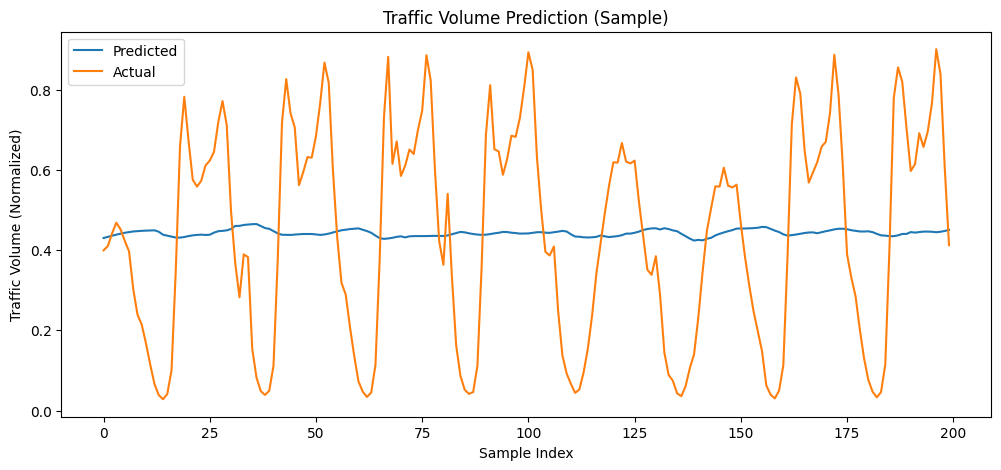

In [4]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy
preds_np = all_predictions.numpy()
labels_np = all_labels.numpy()

# Plot a sample of predictions
plt.figure(figsize=(12,5))
plt.plot(preds_np[:200], label='Predicted')
plt.plot(labels_np[:200], label='Actual')
plt.legend()
plt.title('Traffic Volume Prediction (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume (Normalized)')
plt.show()
